# Comparison of Moving-Average and Autoregressive for Electricity Load Forecasting
* Tutorial based on ["Time Series Analysis Handbook"](https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html) and Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3.
* Modified by: Juan Diego Cardenas Cartagena

## A Very Brief Introduction to Time Series

A time series is a sequence of observations indexed by time, where each observation is a realization of a random variable. Key properties of time series include:

* **Stationarity**: A time series is considered stationary when its statistical properties (e.g., mean, variance, and autocorrelation) remain constant.
* **Trend**: A time series exhibits a trend when it shows a systematic and long-term pattern.
* **Seasonality**: A time series shows seasonality when it contains regular, periodic patterns driven by cyclical factors that repeat at fixed intervals (e.g., daily, monthly, or yearly cycles).

To illustrate these concepts consider the following time series:
<figure>
<center>
<img src="img/stationary.png" />
<figcaption>Figure 1: Stationary time series.  (a) Google closing stock price in 2015; (b) Daily change in the Google stock price in 2015; (c) Annual number of strikes in the US; (d) Monthly sales of new one-family houses sold in the US; (e) Annual price of a dozen eggs in the US (constant dollars); (f) Monthly total of pigs slaughtered in Victoria, Australia; (g) Annual total of Canadian Lynx furs traded by the Hudson Bay Company; (h) Quarterly Australian beer production; (i) Monthly Australian gas production. Image taken from Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: Principles and Practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. </figcaption>
</center>
</figure>

Visual inspection reveals that time series (d), (h), and (i) exhibit **seasonality**, while series (a), (c), (e), (f), and (i) show changing **trend** levels. Time Series (b) and (g) display **stationary** behaviour. Furthermore, while the original stock price (a) is non-stationary, the daily price changes (b) form a stationary series. This demonstrates how differencing—calculating the differences between consecutive observations—can transform non-stationary series into stationary ones by removing trends and seasonality. Of course, we need to prove these properties, particularly stationarity formally.

## Problem Formulation: Forecast Electricity Loads

The PJM dataset contains information about energy consumption and load for PJM Interconnection LLC (PJM), which serves parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The dataset was taken from [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data)

In this tutorial, we will analyze the performance of three models—MA, AR, and ARMA—to forecast the system's energy load based on historical data.

### Requirements

In [1]:
# Requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set figure size and DPI for better resolution
plt.rcParams['figure.figsize'] = [15, 6]

# Set display options for better notebook integration
%matplotlib inline

### Load Data and Exploratory Analysis

                     PJM_Load_MW
Datetime                        
1998-04-01 01:00:00      22259.0
1998-04-01 02:00:00      21244.0
1998-04-01 03:00:00      20651.0
1998-04-01 04:00:00      20421.0
1998-04-01 05:00:00      20713.0


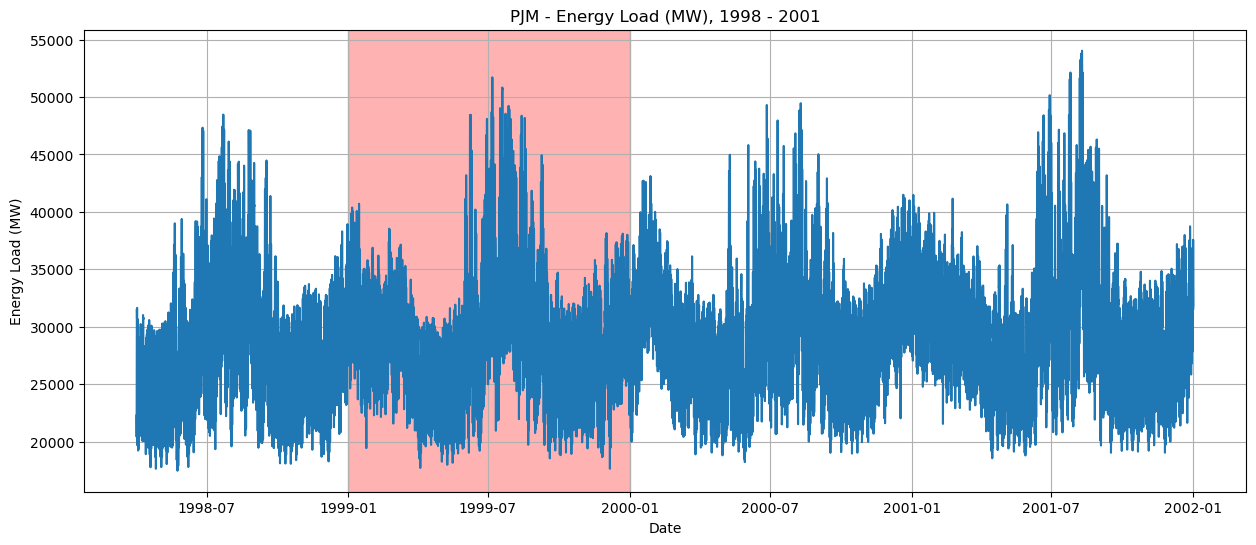

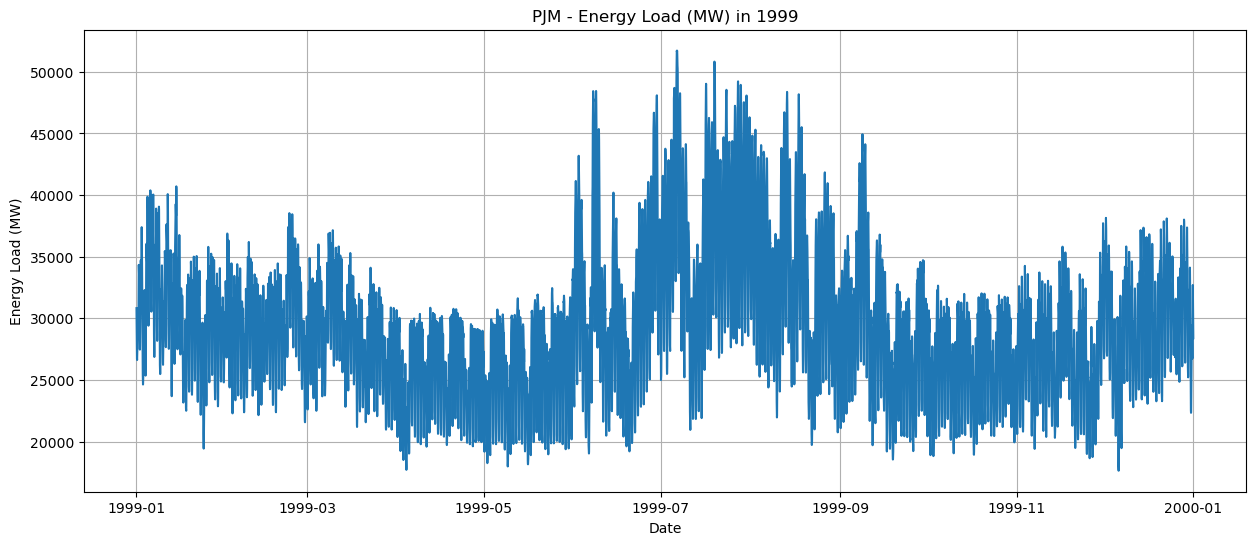

In [2]:
# Load data - Energy Load (MW)
load_df = pd.read_csv('dataset/PJM_Load_hourly.csv')

# Ensure 'Datetime' column is in datetime format
load_df['Datetime'] = pd.to_datetime(load_df['Datetime'])
load_df.set_index('Datetime', inplace=True)

# Ensure the data is numeric
load_df['PJM_Load_MW'] = pd.to_numeric(load_df['PJM_Load_MW'], errors='coerce')

# Hourly frequency
load_df = load_df.asfreq('h')

# Interpolate missing values
load_df['PJM_Load_MW'] = load_df['PJM_Load_MW'].interpolate(method='time')

# Print the first 5 rows
print(load_df.head())

# Figure 1
# Plot the data from 1998 to 2001
plt.plot(load_df)
plt.title('PJM - Energy Load (MW), 1998 - 2001')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')

# Highlight the year 1999
plt.axvspan('1999-01-01', '2000-01-01', color='red', alpha=0.3)

plt.grid()
plt.show()

# Figure 2
# Plot the data in 1999
plt.plot(load_df.loc['1999'])
plt.title('PJM - Energy Load (MW) in 1999')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.grid()
plt.show()

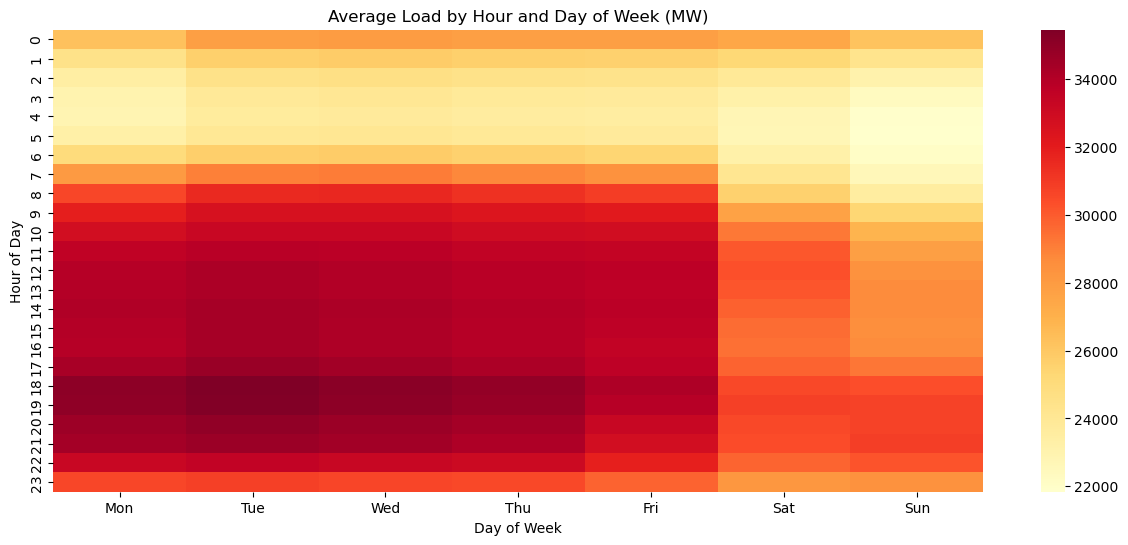

In [3]:
# Let us explore weekly trends and seasonality in the data
# Add day-of-week information
load_df['dayofweek'] = load_df.index.dayofweek  # 0=Monday, 6=Sunday
load_df['hour'] = load_df.index.hour

# Plot average load by day of week and hour
weekly_pattern = load_df.pivot_table(
    values='PJM_Load_MW',  # assuming your column is named 'load'
    index='hour',
    columns='dayofweek',
    aggfunc='mean'
)

# Plot heatmap
sns.heatmap(weekly_pattern, 
            cmap='YlOrRd',
            xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Average Load by Hour and Day of Week (MW)')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.show()

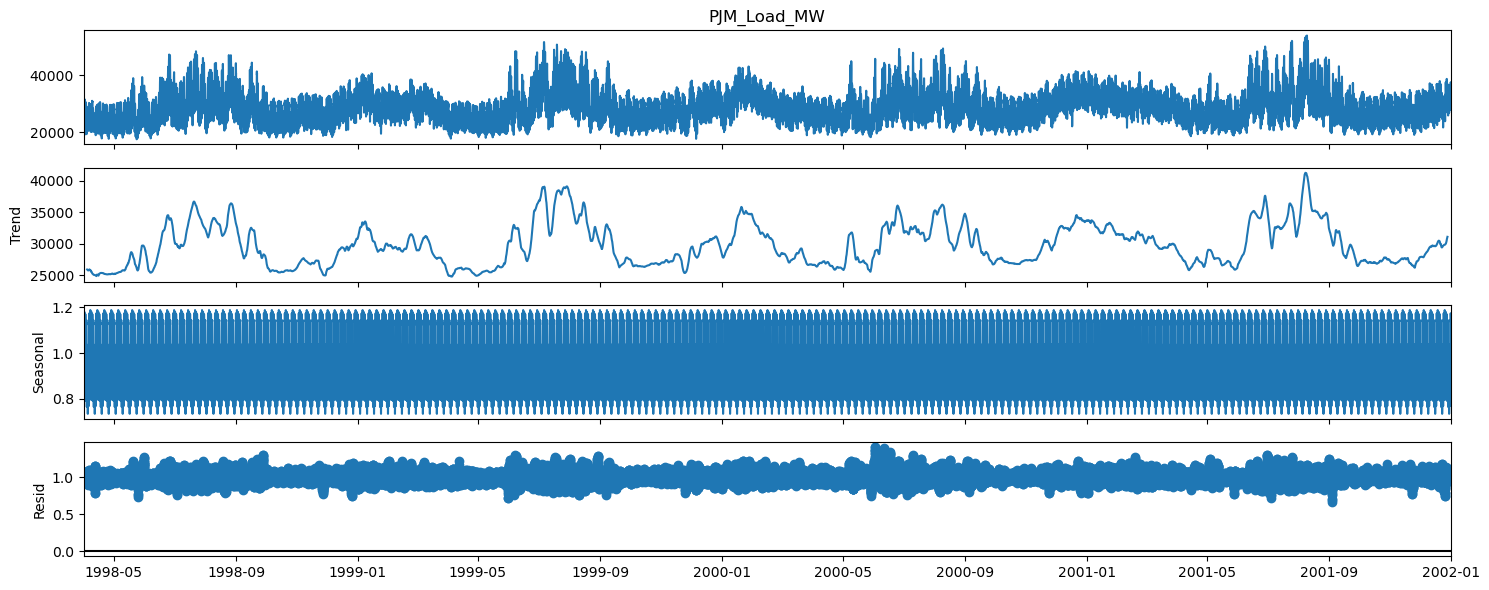

In [4]:
# Let us decompose the time series in trend, seasonality, and residuals
decomposition = sm.tsa.seasonal_decompose(load_df['PJM_Load_MW'], model='multiplicative', period=24*7)
fig = decomposition.plot()
plt.show()

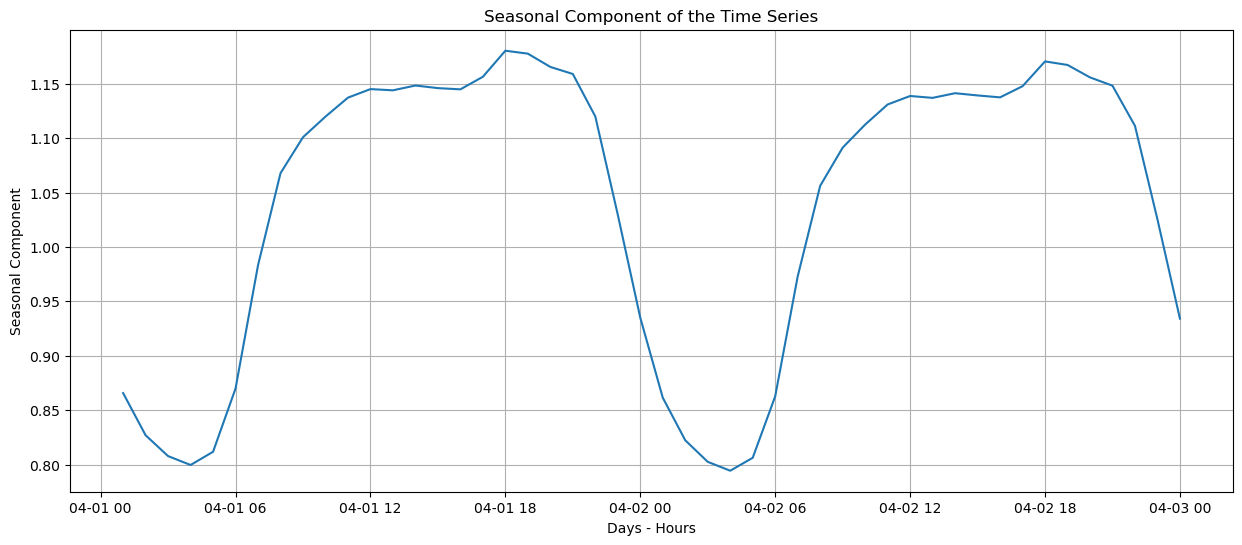

In [5]:
# Show the seasonal component for the first 7 days
plt.plot(decomposition.seasonal[:24*2])
plt.title('Seasonal Component of the Time Series')
plt.xlabel('Days - Hours')
plt.ylabel('Seasonal Component')
plt.grid()
plt.show()

### Stationarity

In [6]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform ADF test
adf_test(load_df['PJM_Load_MW'])

Results of Dickey-Fuller Test:
Test Statistic                -1.317128e+01
p-value                        1.248930e-24
#Lags Used                     5.000000e+01
Number of Observations Used    3.285300e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


**The Augmented Dickey-Fuller (ADF)** test is a statistical test used to determine whether a time series is stationary. The test's null hypothesis is that the time series has a unit root (is **non-stationary**). In our case, we obtained a p-value of 1.248930e-24, which is extremely small. Since this p-value is much smaller than the conventional significance level of 0.05, we strongly reject the null hypothesis, providing strong statistical evidence that our time series is stationary. This means the statistical properties of our data, such as mean and variance, remain constant over time, making it suitable for ARMA modelling.

### Autocorrelation (ACF) and Partial Autocorrelation (PACF)

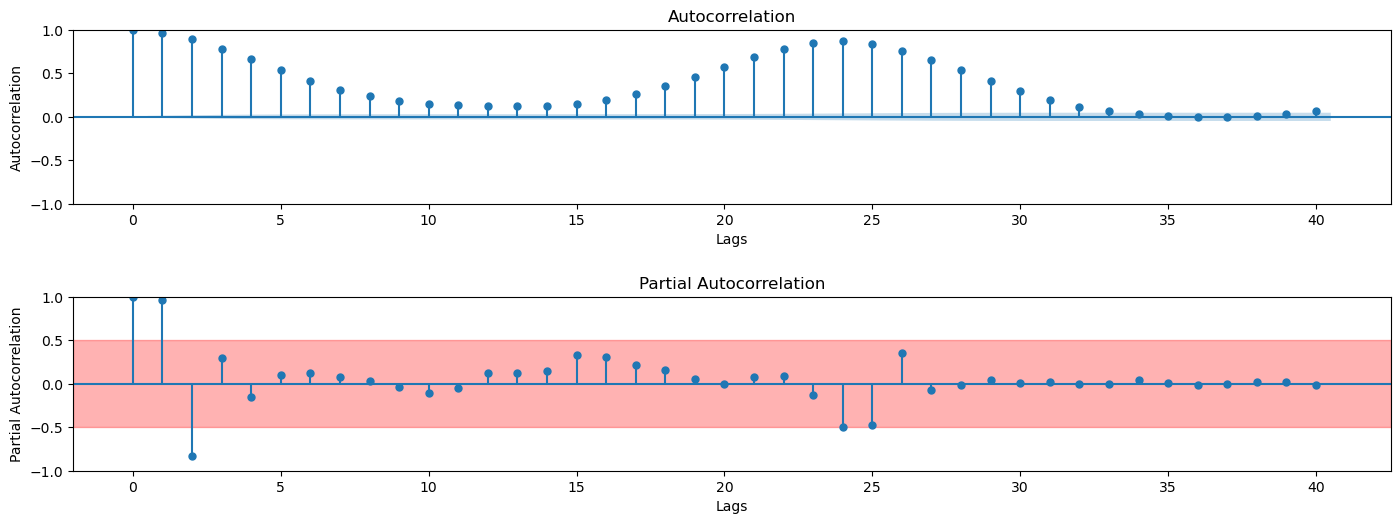

In [7]:
# Autocorrelation plot
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(load_df['PJM_Load_MW'], lags=40, ax=ax1)
fig.tight_layout(pad=5.0)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Autocorrelation')

# Partial Autocorrelation plot
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(load_df['PJM_Load_MW'], lags=40, ax=ax2)
ax2.axhspan(-0.5, 0.5, color='red', alpha=0.3)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Autocorrelation')

plt.show()

**The Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots provide guidance for selecting ARMA model orders. The ACF plot (top) shows significant correlations up to lag 5-6, suggesting an MA(5) or MA(6) component. The PACF plot (bottom) shows strong correlations at lags 1, 2, and 3, indicating an AR(3) component would be appropriate. Both plots also reveal a clear seasonal pattern repeating every 24 lags, which reflects the daily cycle in energy load data. This suggests that a seasonal component might improve the model's performance.

### Split and Normalize Data

In [8]:
# Select the first 12 months of data for training and testing
load_cut_df = load_df['1998-01-01':'1998-12-31']

# Split the data into train (80%) and test (20%)
train_size = int(len(load_cut_df) * 0.85)
train_df = load_cut_df[:train_size]
test_df = load_cut_df[train_size:]

# Normalize the data
train_mean = train_df['PJM_Load_MW'].mean()
train_std = train_df['PJM_Load_MW'].std()

normalized_train_df = (train_df['PJM_Load_MW'] - train_mean) / train_std

# Models: MA(6)-MA(24), AR(3)-AR(24), and ARMA(3, 6)-ARMA(24, 24)

## Moving-Average Models as FIR Filters

**Moving-average (MA)** models have a structure similar to FIR filters, but with a key difference in their input. They have the form
$$
y[n] = \sum_{k = 0}^{q} \beta_{k} x[n - k],
$$
where $y[n]$ is the output signal indexed by time-variable $n$, and $x[n]$ represents input, which is an error term computed as $x[n] = y[n] - \hat{y}[n],$ with $\hat{y}[n]$ being the predicted value. The set of coefficients $\{\beta_{k}\}_{k = 0}^{q}$ determines the weighted contribution of current and past errors and does not necessarily sum to 1. The order of the model is $q$, denoted as MA($q$). 

Although the equation resembles an FIR filter, the recursive computation of the error terms $x[n]$ makes MA models feedback systems rather than purely feedforward ones. We initialize with $x[0] = 0$.

Let us analyze the performance of the MA filter in forecasting the time series.

### MA(6) Model

In [9]:
# MA model
MA_model = ARIMA(normalized_train_df, order=(0, 0, 6))
MA_model_fit = MA_model.fit()
print(MA_model_fit.summary())

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            PJM_Load_MW   No. Observations:                 5609
Model:                 ARIMA(0, 0, 6)   Log Likelihood                3250.931
Date:                Mon, 09 Dec 2024   AIC                          -6485.862
Time:                        11:32:37   BIC                          -6432.805
Sample:                    04-01-1998   HQIC                         -6467.374
                         - 11-20-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.854e-05      0.025     -0.001      0.999      -0.049       0.049
ma.L1          2.2649      0.013    179.448      0.000       2.240       2.290
ma.L2          3.0690      0.029    105.042      0.0

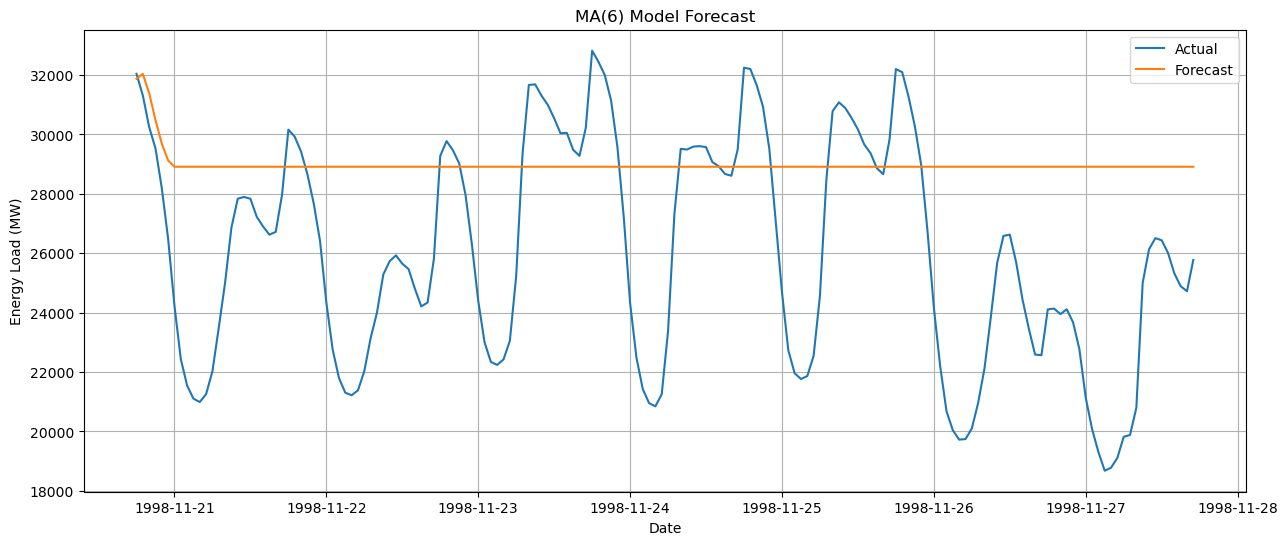

In [10]:
# Forecast the test data
MA_forecast = MA_model_fit.forecast(steps=len(test_df))
MA_forecast = MA_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], MA_forecast[:hours_to_show], label='Forecast')
plt.title('MA(6) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

### MA(24) Model

In [11]:
# MA model
MA_24_model = ARIMA(normalized_train_df, order=(0, 0, 24))
MA_24_model_fit = MA_24_model.fit()
print(MA_24_model_fit.summary())

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            PJM_Load_MW   No. Observations:                 5609
Model:                ARIMA(0, 0, 24)   Log Likelihood                5141.802
Date:                Mon, 09 Dec 2024   AIC                         -10231.605
Time:                        11:35:23   BIC                         -10059.170
Sample:                    04-01-1998   HQIC                        -10171.519
                         - 11-20-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.035     -0.016      0.987      -0.068       0.067
ma.L1          2.0712      0.012    170.410      0.000       2.047       2.095
ma.L2          2.8209      0.028     99.685      0.0

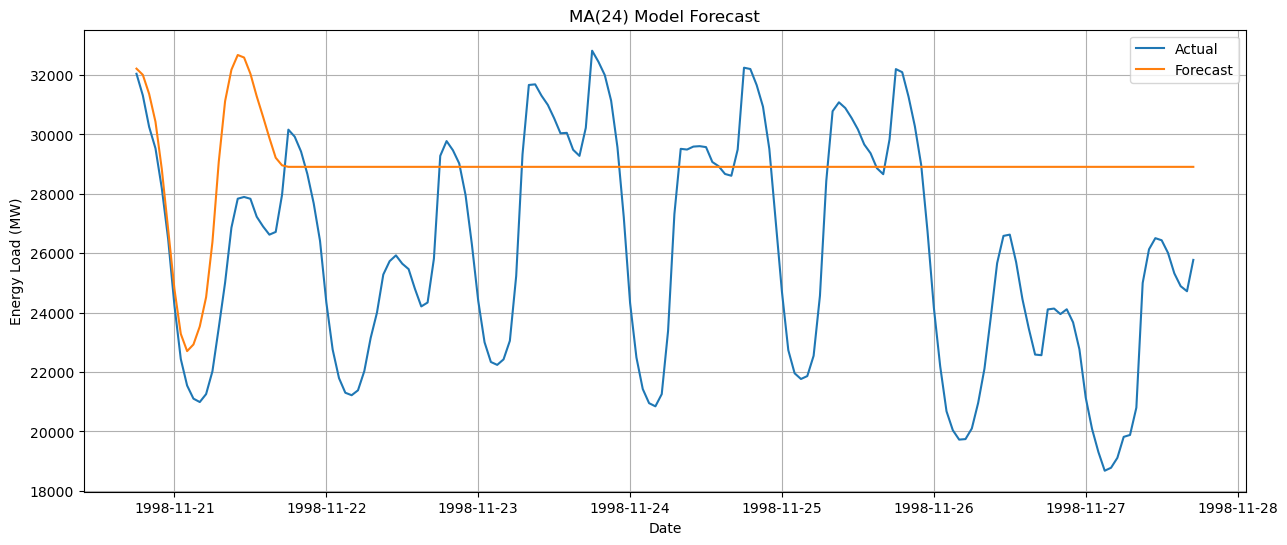

In [12]:
# Forecast the test data
MA_24_forecast = MA_24_model_fit.forecast(steps=len(test_df))
MA_24_forecast = MA_24_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], MA_24_forecast[:hours_to_show], label='Forecast')
plt.title('MA(24) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

## Autoregressive Models as IIR Filters

Autoregressive (AR) filters belong to the family of IIR filters. The output in AR filters is a linear combination of previous outputs plus an innovation term. They have the form:
$$
y[n] = \sum_{l = 1}^{p} \alpha_{l} y[n - l],
$$
where $\{\alpha_{l}\}_{l = 1}^{p}$ is a set of coefficients, and the order of the filter is $p$, denoted as AR($p$). The initial conditions for the filter are $y[0] = 0$.

Let us analyze the performance of the AR filter in forecasting the time series.

### AR(3) Model

In [13]:
# AR model
AR_model = ARIMA(normalized_train_df, order=(3, 0, 0))
AR_model_fit = AR_model.fit()

# Print model summary
print(AR_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            PJM_Load_MW   No. Observations:                 5609
Model:                 ARIMA(3, 0, 0)   Log Likelihood                4040.186
Date:                Mon, 09 Dec 2024   AIC                          -8070.371
Time:                        11:35:27   BIC                          -8037.211
Sample:                    04-01-1998   HQIC                         -8058.816
                         - 11-20-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.352e-07      0.049   6.91e-06      1.000      -0.095       0.095
ar.L1          2.0347      0.011    182.991      0.000       2.013       2.057
ar.L2         -1.3490      0.021    -65.546      0.0

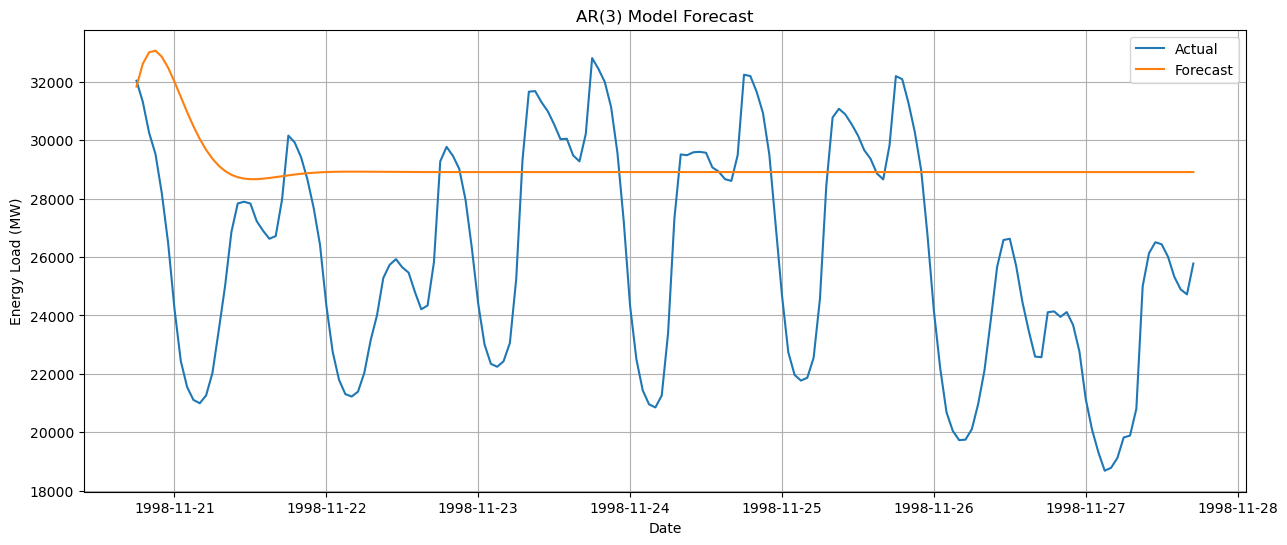

In [14]:
# Forecast the test data
AR_forecast = AR_model_fit.forecast(steps=len(test_df))
AR_forecast = AR_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], AR_forecast[:hours_to_show], label='Forecast')
plt.title('AR(3) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

### AR(24) Model

In [15]:
# AR model
AR_24_model = ARIMA(normalized_train_df, order=(24, 0, 0))
AR_24_model_fit = AR_24_model.fit()

# Print model summary
print(AR_24_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            PJM_Load_MW   No. Observations:                 5609
Model:                ARIMA(24, 0, 0)   Log Likelihood                6101.971
Date:                Mon, 09 Dec 2024   AIC                         -12151.942
Time:                        11:38:04   BIC                         -11979.507
Sample:                    04-01-1998   HQIC                        -12091.856
                         - 11-20-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.146     -0.022      0.983      -0.290       0.283
ar.L1          1.7033      0.010    165.412      0.000       1.683       1.723
ar.L2         -1.0138      0.022    -45.389      0.0

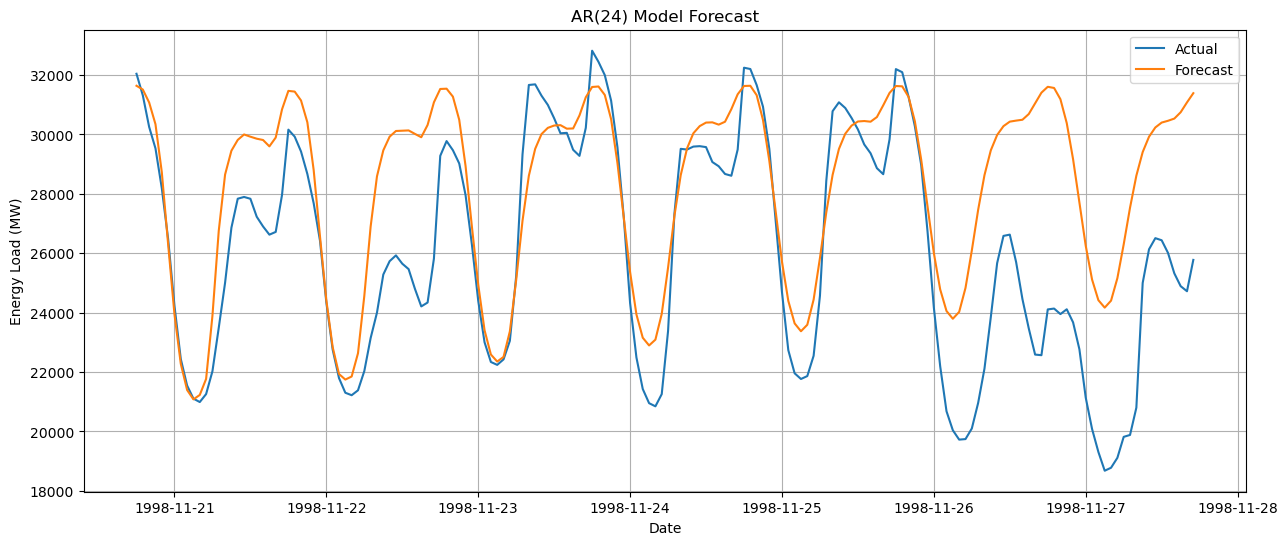

In [16]:
# Forecast the test data
AR_24_forecast = AR_24_model_fit.forecast(steps=len(test_df))
AR_24_forecast = AR_24_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], AR_24_forecast[:hours_to_show], label='Forecast')
plt.title('AR(24) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

## ARMA Models

A combination of AR and MA models leads to an Autoregressive Moving-average (ARMA) models, where the output is a linear combination of previous outputs and error terms. Due to the autoregressive nature of this filter, it belongs to the family of IIR filters. It has the form:
$$
y[n] = \sum_{l = 1}^{p} \alpha_{l} y[n - l] + \sum_{k = 0}^{q} \beta_{k} x[n - k],
$$
where $x[n] = y[n] - \hat{y}[n]$ represents the error between actual and predicted values. In the ARMA filter, $\{\alpha_{l}\}_{l = 1}^{p}$ are the feedback coefficients (AR part) and $\{\beta{k}\}_{k = 0}^{q}$ are the feedforward coefficients (MA part). The order of the filter is $(p, q)$, denoted as ARMA $(p, q)$, where $p$ is the AR order and $q$ is the MA order.

Let us analyze the performance of the ARMA filter in forecasting the time series.

### ARMA(3, 6) Model

In [17]:
# ARMA model
ARMA_model = ARIMA(normalized_train_df, order=(3, 0, 6))
ARMA_model_fit = ARMA_model.fit()

# Print model summary
print(ARMA_model_fit.summary())

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            PJM_Load_MW   No. Observations:                 5609
Model:                 ARIMA(3, 0, 6)   Log Likelihood                4320.867
Date:                Mon, 09 Dec 2024   AIC                          -8619.734
Time:                        11:38:27   BIC                          -8546.781
Sample:                    04-01-1998   HQIC                         -8594.313
                         - 11-20-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.102      0.190      0.849      -0.180       0.219
ar.L1          2.6929      0.016    169.036      0.000       2.662       2.724
ar.L2         -2.5028      0.030    -84.332      0.0

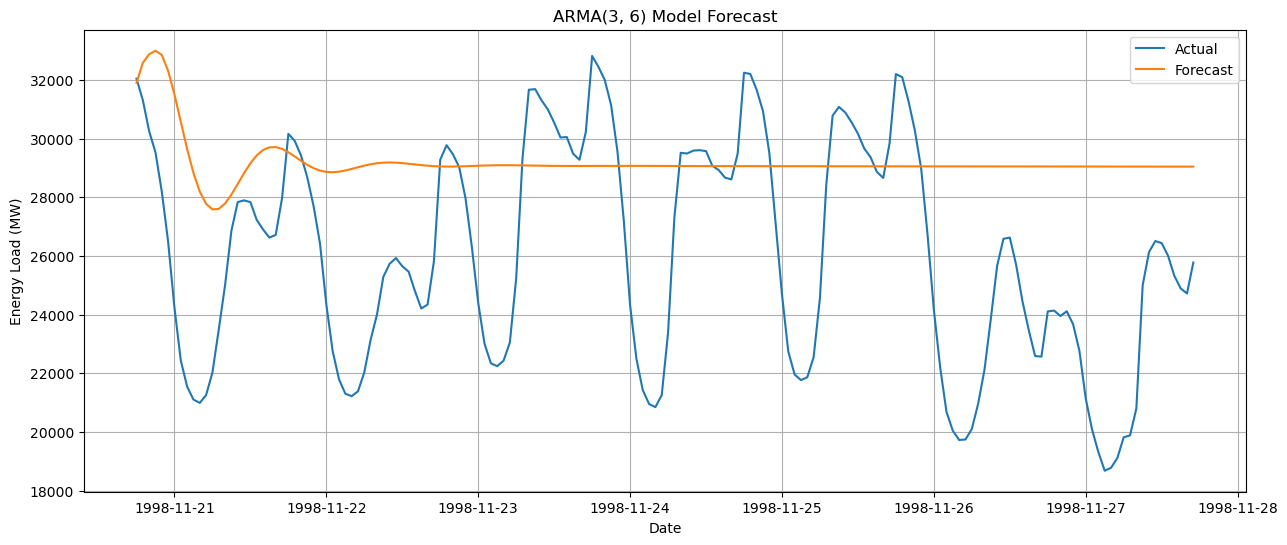

In [18]:
# Forecast the test data
ARMA_forecast = ARMA_model_fit.forecast(steps=len(test_df))
ARMA_forecast = ARMA_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], ARMA_forecast[:hours_to_show], label='Forecast')
plt.title('ARMA(3, 6) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

### ARMA(24, 24) Model

In [19]:
# ARMA model
ARMA_24_model = ARIMA(normalized_train_df, order=(24, 0, 24))
ARMA_24_model_fit = ARMA_24_model.fit()

# Print model summary
print(ARMA_24_model_fit.summary())

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            PJM_Load_MW   No. Observations:                 5609
Model:               ARIMA(24, 0, 24)   Log Likelihood                7090.743
Date:                Mon, 09 Dec 2024   AIC                         -14081.486
Time:                        11:44:00   BIC                         -13749.880
Sample:                    04-01-1998   HQIC                        -13965.937
                         - 11-20-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.165     -0.009      0.993      -0.325       0.322
ar.L1          1.6752      0.050     33.714      0.000       1.578       1.773
ar.L2         -1.3426      0.055    -24.256      0.0

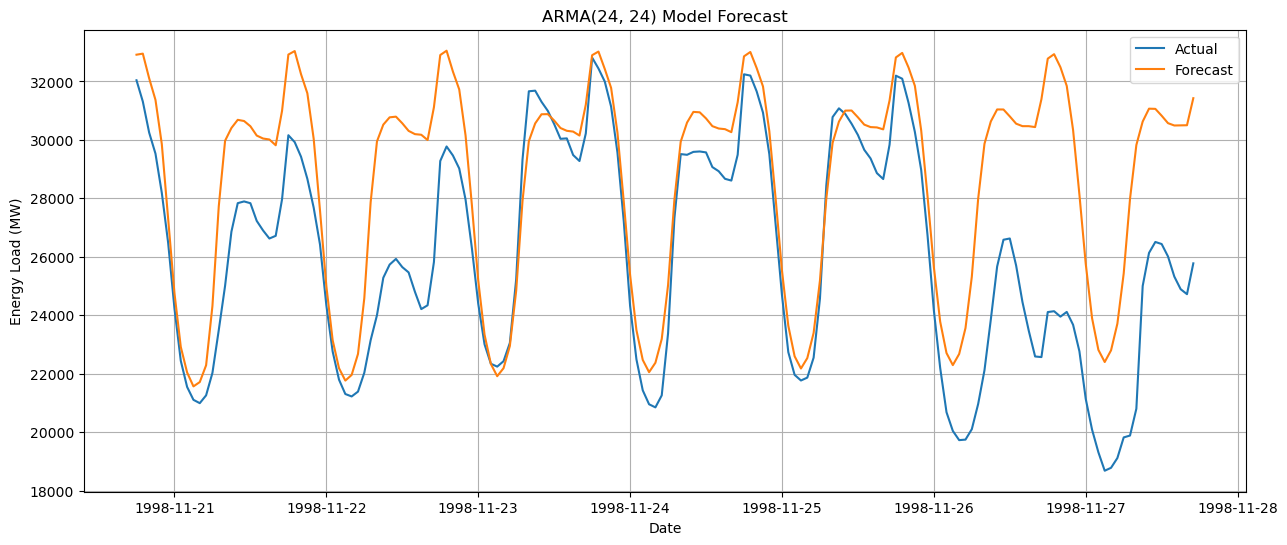

In [20]:
# Forecast the test data
ARMA_24_forecast = ARMA_24_model_fit.forecast(steps=len(test_df))
ARMA_24_forecast = ARMA_24_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], ARMA_24_forecast[:hours_to_show], label='Forecast')
plt.title('ARMA(24, 24) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

## Models with 24-hours seasonality

### Seasonal MA(6) model - 24 hours

In [21]:
# Seasonal MA model with seasonal component
seasonal_MA_model = ARIMA(normalized_train_df, order=(0, 0, 6), seasonal_order=(0,0,1,24))
seasonal_MA_fit = seasonal_MA_model.fit()

# Print model summary
print(seasonal_MA_fit.summary())

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                        PJM_Load_MW   No. Observations:                 5609
Model:             ARIMA(0, 0, 6)x(0, 0, [1], 24)   Log Likelihood                4623.761
Date:                            Mon, 09 Dec 2024   AIC                          -9229.521
Time:                                    11:45:36   BIC                          -9169.832
Sample:                                04-01-1998   HQIC                         -9208.722
                                     - 11-20-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.026     -0.027      0.978      -0.053       0.051
ma.L1          2.0397      0.013   

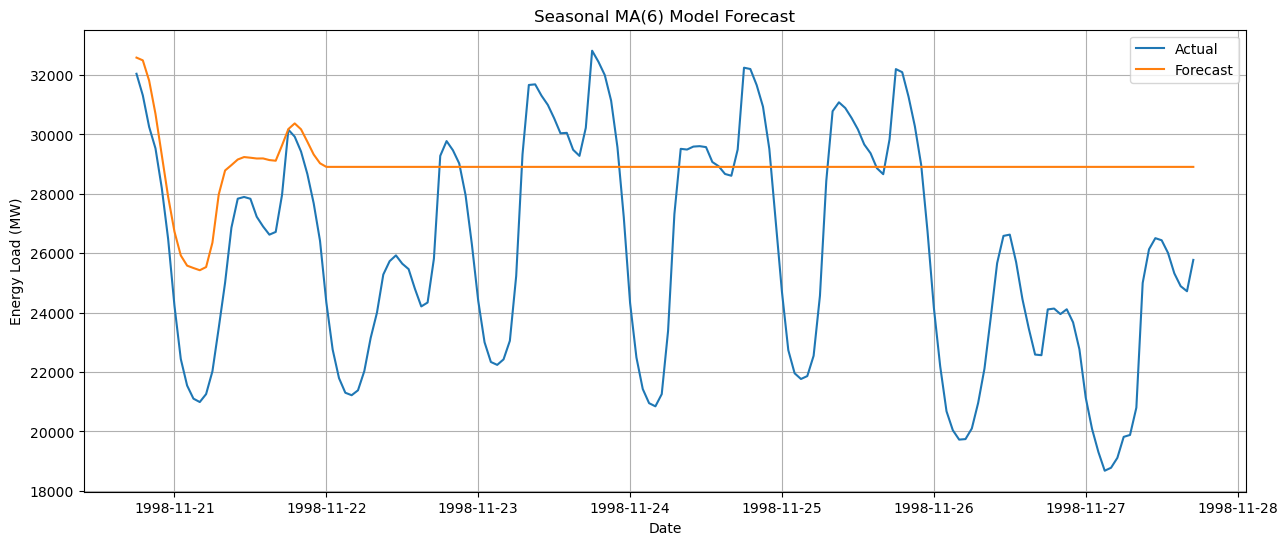

In [22]:
# Forecast the test data
seasonal_MA_forecast = seasonal_MA_fit.forecast(steps=len(test_df))
seasonal_MA_forecast = seasonal_MA_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], seasonal_MA_forecast[:hours_to_show], label='Forecast')
plt.title('Seasonal MA(6) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

### Seasonal AR(3) Model - 24 hours

In [23]:
# Seasonal MA model with seasonal component
seasonal_AR_model = ARIMA(normalized_train_df, order=(3, 0, 0), seasonal_order=(1,0,0,24))
seasonal_AR_fit = seasonal_AR_model.fit()

# Print model summary
print(seasonal_AR_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                      PJM_Load_MW   No. Observations:                 5609
Model:             ARIMA(3, 0, 0)x(1, 0, 0, 24)   Log Likelihood                6881.776
Date:                          Mon, 09 Dec 2024   AIC                         -13751.553
Time:                                  11:46:46   BIC                         -13711.760
Sample:                              04-01-1998   HQIC                        -13737.687
                                   - 11-20-1998                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.222     -0.022      0.982      -0.440       0.430
ar.L1          1.6521      0.009    177.901      0.

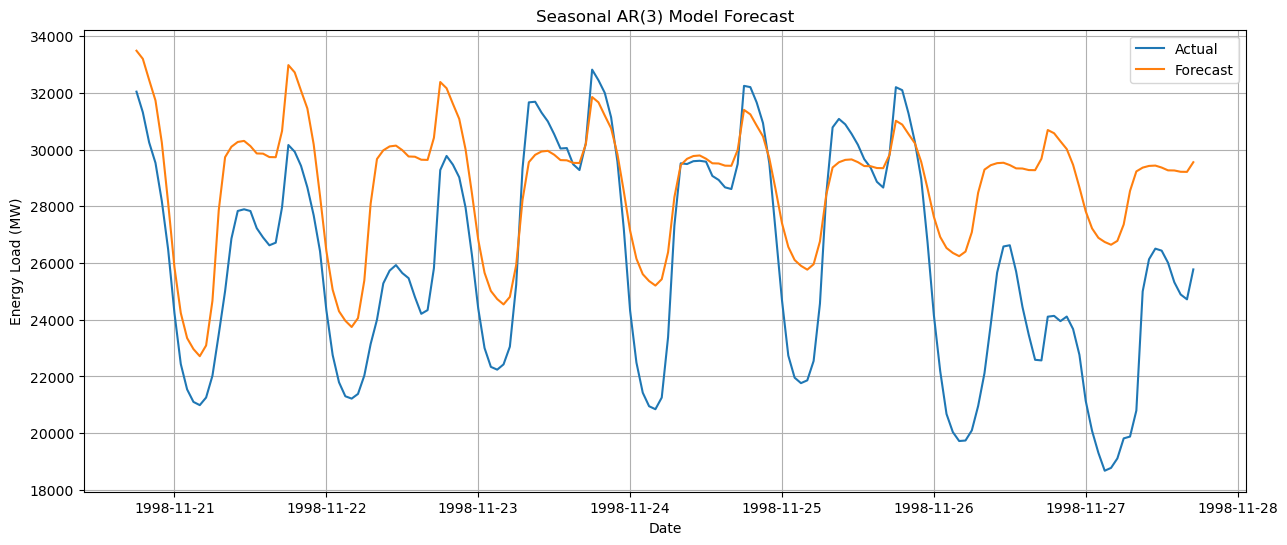

In [24]:
# Forecast the test data
seasonal_AR_forecast = seasonal_AR_fit.forecast(steps=len(test_df))
seasonal_AR_forecast = seasonal_AR_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], seasonal_AR_forecast[:hours_to_show], label='Forecast')
plt.title('Seasonal AR(3) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()

### Seasonal ARMA(3,6) Model - 24 hours

In [25]:
# Seasonal MA model with seasonal component
seasonal_ARMA_model = ARIMA(normalized_train_df, order=(3, 0, 6), seasonal_order=(1,0,1,24))
seasonal_ARMA_fit = seasonal_ARMA_model.fit()

# Print model summary
print(seasonal_ARMA_fit.summary())

c:\Users\P311985\AppData\Local\miniconda3\envs\sas-environment\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        PJM_Load_MW   No. Observations:                 5609
Model:             ARIMA(3, 0, 6)x(1, 0, [1], 24)   Log Likelihood                7345.403
Date:                            Mon, 09 Dec 2024   AIC                         -14664.806
Time:                                    11:49:07   BIC                         -14578.589
Sample:                                04-01-1998   HQIC                        -14634.764
                                     - 11-20-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0160      0.685     -0.023      0.981      -1.359       1.327
ar.L1          2.7581      0.014   

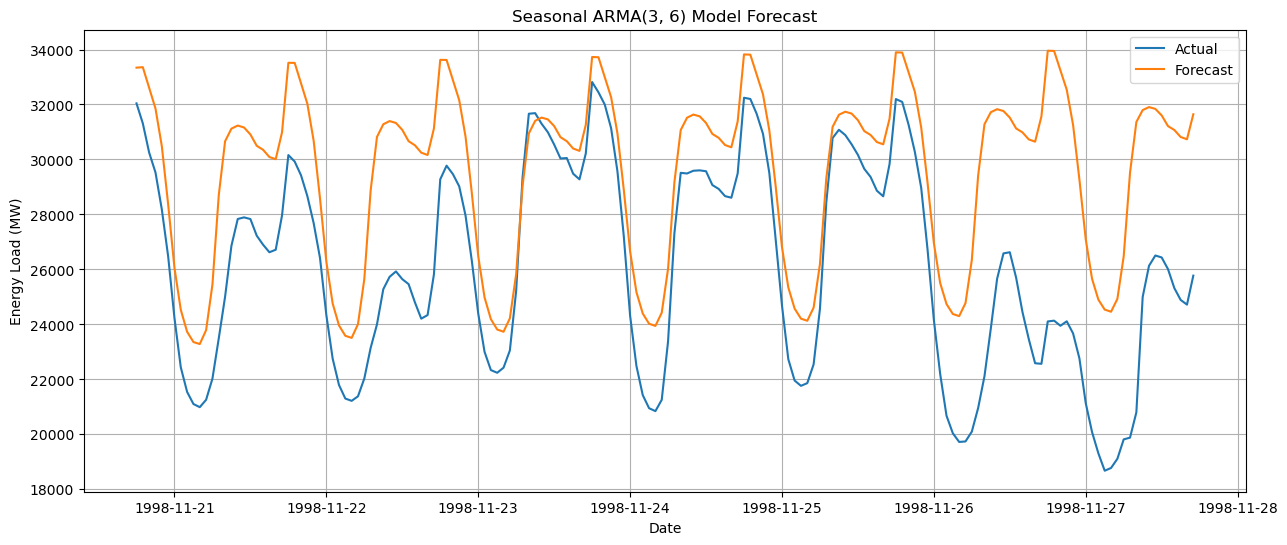

In [26]:
# Forecast the test data
seasonal_ARMA_forecast = seasonal_ARMA_fit.forecast(steps=len(test_df))
seasonal_ARMA_forecast = seasonal_ARMA_forecast * train_std + train_mean

# Plot the forecast
hours_to_show = 24*7

plt.plot(test_df.index[:hours_to_show], test_df['PJM_Load_MW'][:hours_to_show], label='Actual')
plt.plot(test_df.index[:hours_to_show], seasonal_ARMA_forecast[:hours_to_show], label='Forecast')
plt.title('Seasonal ARMA(3, 6) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid()
plt.show()